**YOUR NAMES HERE**

Fall 2023

CS 343: Neural Networks

Project 4: Transfer Learning

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import tf_util
from neural_style import NeuralStyleTransfer

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

2023-12-10 19:54:05.628199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 4: Neural Style Transfer

This this task, you will make use of a pre-trained neural network to generate (`VGG19`) to generate art using an approach called **Neural Style Transfer**. The overall algorithm is quite similar to Deep Dream: we iteratively modify a **generated image** of your choice based on the neural network gradients. In Neural Style Transfer, however, we maintain two additional images:
1. **Style image**: A different image than the generated image, but has same shape. As Neural Style Transfer runs, the generated image maintains its appearance (e.g. Miller keeps looking like Miller), but the generated image increasingly adopts the *style* of the style image. For example, if the style image is an image of a painting that has visible brush strokes, the generated image will look like it is a painting drawn with brush strokes (e.g. the photograph of Miller will start looking like a painted drawing of Miller)!
2. **Content image:** A copy of the initial generated image that *does not change* as Neural Style Transfer runs. 

The reason for the introduction of a content image that is distinct from the generated image is that the loss function used in Neural Style Transfer tries to balance two things:
1. Preserve the original content of the content image (e.g. image should still look like Miller).
2. Adopt the style of the style image.

In other words, Neural Style Transfer simultaneously tries to minimize the discrepency (i.e. error) in the generated image between the content of the content image and the style of the style image. The generated image keeps changing so the content image serves as a stable reference for the target image content.

### Overview
<!-- 
1. Load in the VGG19 pre-trained network without the output layer.
2. Make a `keras` "Model" that allows us extract activations (`netActs`) within the subset of VGG19 network layers of our choice. Neurons in these layers of the VGG19 network will "dream": modify the input image to amplify patterns that the cells "want to see" based on their learned weight patterns. 
3. Select the types of layers (e.g. conv, pooling, etc) that we want to use to run Deep Dream on to influence the input (generated) image.
4. Pass image through the readout network model, compute the netAct values and gradient at the selected layers.
5. Do gradient ascent where we add a proportion of the gradient from a network layer back into the generated image for some number of iterations. -->

### 4a. Load in content and style images

The content image that we will use for testing/development is `miller_224x224.jpg`, a photograph of Miller library in winter, and the style image is `starry_night_224x224.jpg`, the famous oil-on-canvas painting by Vincent van Gogh.

Below, reproduce your workflow from Deep Dream:
- Load in the content and style test images at 224 x 224 resolution. This matches the resolution of images on which VGG19 was trained.
- Normalize each image so that pixel values may span (0, 1) rather than (0, 255). You should **not** use min-max normalization here!
- Make a plot of the content and style images.

In [3]:
raw_con = Image.open("data/miller3_224x224.jpg")
content_img = np.asarray(raw_con)/255
raw_style = Image.open("data/starry_night_224x224.jpg")
style_img = np.asarray(raw_style)/255

In [4]:


# Keep this test code
print(f'Style image shape is {style_img.shape} and should be (224, 224, 3)')
print(f'Style image min/max is: {style_img.min()}/{style_img.max()}. It should be 0.0/1.0')
print(f'Content image shape is {content_img.shape} and should be (224, 224, 3)')
print(f'Content image min/max is: {content_img.min()}/{content_img.max()}. It should be 0.0/1.0')

Style image shape is (224, 224, 3) and should be (224, 224, 3)
Style image min/max is: 0.0/1.0. It should be 0.0/1.0
Content image shape is (224, 224, 3) and should be (224, 224, 3)
Content image min/max is: 0.0/1.0. It should be 0.0/1.0


### 4b. Create the initial generated image

In the cell below, create the generated image: take the content image and add 20% noise. This means adding an independent random value to every pixel between 0 and 0.2 (at most 20% noise).

We still want the generated image to have pixel values between 0 and 1 so **clip** the pixel values:
- Anything less than 0 gets set to 0.
- Anything greater than 1 gets set to 1.

*Note: Clipping is DIFFERENT than normalization!*

Plot the generated image below. It should look like the content image, but have a slight speckled pattern (i.e. RGB noise) throughout the image.

In [5]:
ran_values = np.random.uniform(0, 0.2, size=(224,224,3))
ran_values = ran_values.reshape((224, 224, 3))
gen_image = content_img + ran_values
gen_img_tf = tf.constant(gen_image)
gen_img_tf_clipped = tf.clip_by_value(gen_img_tf, clip_value_min=0, clip_value_max=1)
generated_img = np.array(gen_img_tf_clipped)

In [6]:


print(f'Generated image shape is {generated_img.shape} and should be (224, 224, 3)')
print(f'Generated image max is: {generated_img.max()}. It should be 1.0')
print(f'Generated image min is ≥ 0? {generated_img.min() >= 0}')

Generated image shape is (224, 224, 3) and should be (224, 224, 3)
Generated image max is: 1.0. It should be 1.0
Generated image min is ≥ 0? True


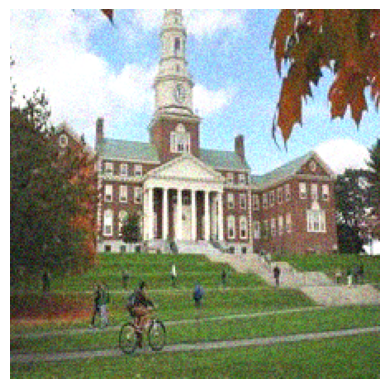

In [7]:
generated_img_norm = generated_img*255
img = Image.fromarray(generated_img_norm.astype(np.uint8))
fig = plt.figure()
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

### 4c. Load pretrained net and define selected layers

Just like Deep Dream, we import a pretrained network (`VGG19`) and define a list of layer names whose netActs will contribute to the loss. The difference with Neural Style Transfer is that we create two separate lists of selected layers names, one for the style and the other for the content. The net activation in the selected style layers will be used to capture the "style" of the style image. Analogously, the net activation in the selected content layers will be used to capture the "content" of the content image.

In the cell below, adapt your Deep Dream notebook code to:
- Import the `VGG19` network.
- Create a list of all the network layer names.
- Create a list of selected style layers: those that have `'conv1'` in their name.
- Create a list of selected content layers: a single layer called `'block4_conv2'`.

In [8]:
pretrained_net = tf_util.load_pretrained_net("vgg19")
pretrained_net.summary()
layer_names = tf_util.get_all_layer_strs(pretrained_net)
style_layer_names = tf_util.filter_layer_strs(layer_names, match_str='conv1')
content_layer_names = tf_util.filter_layer_strs(layer_names, match_str='block4_conv2')

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:


print(f'Your full list of layers contains {len(layer_names)} names and it should contain 22.')
print(f'Your first layer name is {layer_names[0]} and it should be input_2.')
print(' It is not a problem if you have a different int after the underscore (e.g. input_3)')
print(f'Your last layer name is {layer_names[-1]} and it should be block5_pool.')

print()
print(f'Your selected style layer names are:\n{style_layer_names}\nand they should be')
print("['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']")
print(f'Your selected content layer names are:\n{content_layer_names}\nand they should be')
print("['block4_conv2'']")

Your full list of layers contains 22 names and it should contain 22.
Your first layer name is input_1 and it should be input_2.
 It is not a problem if you have a different int after the underscore (e.g. input_3)
Your last layer name is block5_pool and it should be block5_pool.

Your selected style layer names are:
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
and they should be
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
Your selected content layer names are:
['block4_conv2']
and they should be
['block4_conv2'']


### 4d. Preprocess and convert images to tensors

Use your image-to-tensor conversion function to convert your style, content, and generated images into TensorFlow tensors.

**Notes:**
- Your style and content images should be `tf.constant` since they will not be modified.
- Your generated image should be a `tf.Variable` since it will be modified and we want TensorFlow to track gradients derived from it during the forward pass.

In [10]:
content_img_tf = tf_util.preprocess_image2tf(content_img*255, False)
style_img_tf = tf_util.preprocess_image2tf(style_img*255, False)
generated_img_tf = tf_util.preprocess_image2tf(generated_img*255, True)

In [11]:


# Test code: Keep me!
print(f'{style_img_tf.shape=}\n{content_img_tf.shape=}\n{generated_img_tf.shape=}')
print('All 3 should have the same shape: TensorShape([1, 224, 224, 3])')
print(f'Style image is a tf.Variable?', hasattr(style_img_tf, 'trainable'), 'and it should be False.')
print(f'Conent image is a tf.Variable?', hasattr(content_img_tf, 'trainable'), 'and it should be False.')
print(f'Generated image is a tf.Variable?', hasattr(generated_img_tf, 'trainable'), 'and it should be True.')

style_img_tf.shape=TensorShape([1, 224, 224, 3])
content_img_tf.shape=TensorShape([1, 224, 224, 3])
generated_img_tf.shape=TensorShape([1, 224, 224, 3])
All 3 should have the same shape: TensorShape([1, 224, 224, 3])
Style image is a tf.Variable? False and it should be False.
Conent image is a tf.Variable? False and it should be False.
Generated image is a tf.Variable? True and it should be True.


### 4e. Neural Style Transfer constructor and readout models

In `neural_style.py` implement the following methods in the `NeuralStyleTransfer` class:
- Constructor
- `initialize_readout_models(self, style_layer_names, content_layer_names)`: Sets the `style_readout_model` and `content_readout_model` instance variables.

The style readout model is a `tf.keras.Model` that returns the netAct values in the selected style layers. These netAct values are used to define/measure the "style characteristics" of the style image. The content readout model is a `tf.keras.Model` that returns the netAct values in the selected content layers. These netAct values are used to define/measure the "content" of the content image.

#### Test: Style and content readout models


In [12]:
nst = NeuralStyleTransfer(pretrained_net, style_layer_names, content_layer_names)

tf.random.set_seed(0)
test_img = tf.random.uniform(shape=(1, 224, 224, 3))
test_style_net_acts = nst.style_readout_model(test_img)
print(f'The number of layers in style readout model is {len(test_style_net_acts)} and it should be 5.')
print(f'The shape of the first style layer is {test_style_net_acts[0].shape} and it should be (1, 224, 224, 64).')
print(f'The sum of the first style layer netActs is {tf.reduce_sum(test_style_net_acts[0])} and it should be 1522058.5')
print(f'The shape of the last style layer is {test_style_net_acts[-1].shape} and it should be (1, 14, 14, 512).')
print(f'The sum of the last style layer netActs is {tf.reduce_sum(test_style_net_acts[-1])} and it should be 69220.28125')
print()

test_content_net_acts = nst.content_readout_model(test_img)
print(f'The number of layers in content readout model is {len(test_content_net_acts)} and it should be 1.')
print(f'The shape of the content layer is {test_content_net_acts[0].shape} and it should be (28, 28, 512).')
print(f'The sum of the content layer netActs is {tf.reduce_sum(test_content_net_acts[0])} and it should be 2548944.25')

The number of layers in style readout model is 5 and it should be 5.
The shape of the first style layer is (1, 224, 224, 64) and it should be (1, 224, 224, 64).
The sum of the first style layer netActs is 1522058.5 and it should be 1522058.5
The shape of the last style layer is (1, 14, 14, 512) and it should be (1, 14, 14, 512).
The sum of the last style layer netActs is 69220.28125 and it should be 69220.28125

The number of layers in content readout model is 1 and it should be 1.
The shape of the content layer is (28, 28, 512) and it should be (28, 28, 512).
The sum of the content layer netActs is 2548944.0 and it should be 2548944.25


### 4f. Implement style loss methods

Neural Style Transfer quantifies the "style of an image" as the correlation (i.e. multiplication) of each filter's netAct with all the other netActs within the same layer. Such an operation can be achieved by multiplying the matrix of netAct values with itself. To make the shapes work, we have to transpose the right-hand matrix. The result is called the **Gram matrix** (G):

$$
G = AA^T
$$

where $A$ is the matrix of netActs (shape: `(K, rest)`) within a single layer and `rest` is the reshaped/flattened product of the other dimensions (for example, if the netAct shape is `(1, 224, 224, 64)`, the shape of $A$ would be `(64, 1*224*224)`). The loss within the layer is computed as:

$$
\text{layerLoss} = \frac{1}{2K^2I_y^2I_x^2}\sum_{\text{all inds}} (G_{\text{style}} - G_{\text{gen}})^2
$$

**Remember:** The loss will be a scalar value (per layer in this case, since the above is all for one selected layer).

To compute the **total style loss**, we repeat the above process and averaging the layer losses across all *selected* style layers:

$$
L_{\text{style}} = \frac{1}{N_{\text{style layers}}} \sum_{l=0}^{N_{\text{style layers}} - 1}\text{layerLoss}_l
$$

where $N_{\text{style layers}}$ is the number of selected style layers.

The layers to implement and test are:
- `gram_matrix`
- `style_loss_layer`
- `style_loss`

#### (i) Test: Gram matrix

In [21]:
tf.random.set_seed(0)
A = tf.random.uniform(shape=(5, 5), minval=-5, maxval=5, dtype=tf.int32)
tf.print('When A is:\n', A)
tf.print('Your Gram matrix is:\n', nst.gram_matrix(A))
print('and it should be:')
print('''[[44 -30 24 16 -12]
 [-30 44 4 -6 39]
 [24 4 47 4 24]
 [16 -6 4 52 2]
 [-12 39 24 2 47]]
''')

When A is:
 [[-2 4 -4 2 2]
 [-1 -5 4 1 1]
 [-5 2 1 1 4]
 [4 2 0 4 4]
 [-3 -3 4 3 2]]
Your Gram matrix is:
 [[44 -30 24 16 -12]
 [-30 44 4 -6 39]
 [24 4 47 4 24]
 [16 -6 4 52 2]
 [-12 39 24 2 47]]
and it should be:
[[44 -30 24 16 -12]
 [-30 44 4 -6 39]
 [24 4 47 4 24]
 [16 -6 4 52 2]
 [-12 39 24 2 47]]



#### (ii) Test: `style_loss_layer`

In [22]:
tf.random.set_seed(0)
gen_layer_net_acts = tf.random.uniform(shape=(1, 5, 5, 3), minval=-5, maxval=5, dtype=tf.float32)
style_layer_net_acts = tf.random.uniform(shape=(1, 5, 5, 3), minval=-5, maxval=5, dtype=tf.float32)
tf.print(f'Your layer style loss is {nst.style_loss_layer(gen_layer_net_acts, style_layer_net_acts):.3f} and should be {2.605:.3f}')

Your layer style loss is 2.162 and should be 2.605


#### (iii) Test: `style_loss`

In [23]:
tf.random.set_seed(0)
gen_net_acts = []
style_net_acts = []
test_shapes = [(1, 7, 7, 4), (1, 9, 9, 2), (1, 2, 2, 3), (1, 4, 4, 3), (1, 5, 5, 3)]
# Test out 5 selected style layers
for l in range(5):
    gen_net_acts.append(tf.random.uniform(shape=test_shapes[l], minval=-5, maxval=5, dtype=tf.float32))
    style_net_acts.append(tf.random.uniform(shape=test_shapes[l], minval=-5, maxval=5, dtype=tf.float32))
tf.print(f'Your total style loss across {len(style_net_acts)} layers is {nst.style_loss(gen_net_acts, style_net_acts):.3f} and should be {4.275:.3f}')

Your total style loss across 5 layers is 2.789 and should be 4.275


### 4f. Implement content loss

Unlike the style loss, the content loss is often computed based on a single layer. The computation is similar to the style loss, except there is no Gram matrix. The content loss is the mean squared difference between the selected layer netActs in the generated ($\text{netAct}_{\text{generated}}$) and content ($\text{netAct}_{\text{content}}$) images:

$$
\text{L}_{\text{content}} = \frac{1}{2KI_yI_x}\sum_{\text{all inds}} (\text{netAct}_{\text{generated}} - \text{netAct}_{\text{content}})^2
$$

*Note: For simplicity, we are just going to assume that we will pick a single content layer, but feel free to add support for multiple layers if you would like. To compute the content loss over several layers, you would just average the loss contributions from each layer, just like in the case of the style loss.*

The layers to implement and test are:
- `content_loss`

#### Test: `content_loss`
 

In [ ]:
tf.random.set_seed(0)
gen_layer_net_acts = tf.random.uniform(shape=(1, 4, 4, 3), minval=-10, maxval=10, dtype=tf.float32)
content_layer_net_acts = tf.random.uniform(shape=(1, 4, 4, 3), minval=-10, maxval=10, dtype=tf.float32)
tf.print(f'Your content loss is {nst.content_loss(gen_layer_net_acts, content_layer_net_acts):.3f} and should be {41.333:.3f}')

Your content loss is 41.333 and should be 41.333


### 4g. Implement total loss

The total loss is defined as a weighted sum of the style loss (*averaged across layers*) and the content loss (*from the single content layer*):

$$
L = \alpha L_{\text{style}} + \beta L_{\text{content}}
$$

where $\alpha$ is the weight for the style loss and $\beta$ is the weight for the content loss. Both are hyperparameters. The default values are `1e2` for $\alpha$ and `1` for $\beta$. 

#### Test: `total_loss`

In [19]:
test_total = nst.total_loss(3.5, 2, 5.0, 3)
tf.print(f'Your total loss is {test_total:.3f} and should be {22.000:.3f}')

Your total loss is 22.000 and should be 22.000


### 4h. Implement forward pass

Your implementations should be very similar to your `forward` method in Deep Dream. The main difference is that the netActs to the generated image need to be obtained from the content and style layers separately. Use these netActs to compute the style loss, content loss, and ultimately the total loss.

#### Test `forward`

In [ ]:
tf.random.set_seed(0)
test_gen_img = tf.Variable(tf.random.uniform(shape=(1, 224, 224, 3)))
test_style_img = tf.random.uniform(shape=(1, 224, 224, 3))
test_content_img = tf.random.uniform(shape=(1, 224, 224, 3))
loss, grads = nst.forward(test_gen_img,
                          nst.style_readout_model(test_style_img),
                          nst.content_readout_model(test_content_img),
                          1,
                          2)
print(f'After 1 forward pass, your loss is {loss:.3f} and should be 47.531')
tf.print(f'Your first few gradients are\n{grads[0,0,:4,:]}')
print('and they should be:')
print('''[[-0.012 -0.024 -0.028]
 [-0.018 -0.035 -0.043]
 [-0.019 -0.034 -0.042]
 [-0.025 -0.033 -0.044]]
''')


tf.Tensor(7.92184, shape=(), dtype=float32)
After 1 forward pass, your loss is 34.777 and should be 47.531
Your first few gradients are
[[-0.002 -0.009 -0.008]
 [ 0.019  0.016  0.015]
 [ 0.027  0.028  0.026]
 [ 0.008  0.01   0.011]]
and they should be:
[[-0.012 -0.024 -0.028]
 [-0.018 -0.035 -0.043]
 [-0.019 -0.034 -0.042]
 [-0.025 -0.033 -0.044]]



### 4i. Implement `fit` and iteratively modify the style of the generated image

Your implementation should be very similar to `fit` in Deep Dream. The key difference is that you should obtain the netActs for the style and content images. This only needs to happen *once* since these images do not change. 

#### Test: Neural Style Transfer for 1 epoch

The code below runs `fit` for one epoch.
- You should print out the estimated amount of time in minutes to complete `E` epochs.
- You should print out how many epochs have been completed out of `E` total. This should happen on the first epoch (and in general `print_every` epochs).
- `fit` should generate a plot showing the generated image after 1 epoch. *You should see a wavy brush stroke texture start to emerge in the generated image*!
- You should export a JPG of the generated image in the `neural_style_output` folder within your project working directory (*create it if it doesn't exist*). 

In [ ]:
gen_img_1epoch = tf.Variable(tf.identity(generated_img_tf))
loss_hist = nst.fit(gen_img_1epoch, style_img_tf, content_img_tf, lr=0.05, n_epochs=1)
print('Test code:')
print(f'Generated image min/max pixel values are {tf.reduce_min(gen_img_1epoch)}/{tf.reduce_max(gen_img_1epoch)} and should be 0.0/1.0')

### 4j. Starry Night Miller

Write code below to run Neural Style Transfer on Miller for additional epochs, enough to clearly show Miller Library painted in the style of van Gogh's Starry Night. The default hyperparameters should work fine. It might be helpful to make a deep copy of the initial generated image across runs so that run of Neural Style Transfer starts with the original generated image (*content image with some added noise*) — NOT the output of the previous Neural Style Transfer run! This can be achieved with:

```python
generated_img_tf = tf.Variable(tf.identity(generated_img_tf))
```

#### Suggestions

- Smaller learning rates require more time for the image to change, but may result in more aesthetically pleasing results. You probably want to decrease it from the test code above — it was large so that clear changes would be noticeable after 1 epoch.
- Set `fit` parameters to get frequent feedback on training (and exported images), but printing/exporting too often isn't helpful either and can slow things down.

### 4k. Run Neural Style Transfer with at least one more content and style image pair

Write and/or copy-and-paste code from above to load the pretrained net, identify the content and style layers, preprocess images, and run Neural Style Transfer. Make it so the below cell **self-contained**: executing the cell below should run Neural Style Transfer without needing to execute any other cells.

Change the content and style images (*use provided examples or your own!*) and run Neural Style Transfer.

### Runtime suggestions

If training is taking too long on your computer to get reasonable results, you might try using a different pretrained network that runs faster. For example, MobileNetV2 runs ~3x faster per epoch than VGG19 on my computer. There may be some slight decline in the quality in the style transfer. If you go this route, all you should need to do is add support for MobileNetV2 in `tf_util.load_pretrained_net` (~1 line of code). As for the content and style layers, here are suggested starting points:

```python
style_layer_names = ['block_4_expand', 'block_8_expand', 'block_12_expand', 'block_15_expand']
content_layer_names = ['block_8_expand_BN']
```

## Extensions

### 1. Run Deep Dream or Neural Style Transfer on your own images. Make some interesting effects.

Change hyperparameters as needed to get cool results.

### 2. Research other pretrained networks in tensorflow and run Deep Dream and/or Neural Style Transfer on their layers/filters.

### 3. Deep Dream: Visualize individual CNN filters

- Rather than having the netActs from each entire layer influence the generated image, only have the netAct values of specific filters influence the generated image. This feature is is potentially interesting/useful for analysis because you can visualize what shape/object/animal/texture a particular filter learns (e.g. filter at index 0 learns seals, filter at index 1 learns birds, filter at index 2 learns fish, etc). This would involve defining a list of indices to sample within all or specific layers.
- You can use this approach to visualize the features that a CNN filter learns at any depth of the network. Instead of presenting the network with an actual image, apply Deep Dream to an image of RGB noise. The selected filter will amplify patterns/textures that are consistent with those to which it is tuned.

### 4. Neural Style Transfer: Regularize by total variational loss

You can control how smooth the texture in the generated image appears by incorporating the summed differences between all netAct values in the generated image and its neighbors in the loss computation (total variational loss). This would be another component in the total loss computation, aside from the style and content losses. Just like the style and content losses, there should be a weighting factor (hyperparameter) that controls the degree of contribution toward the total loss.

Demonstrate the implementing and including total variational loss modulates the smoothness of the generated image (with different values of the weighting factor hyperparameter).

### 5. Transfer learning: What's the best test accuracy that you can achieve on the hot dog or not dataset? How did you do it?

### 6. Keras ConvNet4: Explore and analyze how different network architectures affect the STL-10 results.

### 7. Transfer learning: Can you apply Transfer learning to a binary or multi-class classification task with another dataset of your choice?

### 8. Neural Style Transfer: Analyze effects of using different layers for style and content readouts.

How does the choice depend on the layer type (conv, max pooling, etc.) and depth in the network?